<a href="https://colab.research.google.com/github/shrutin0492/iNNvestigate-XAI-Project/blob/main/Demo_iNNvestigate_AM0120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Explainable AI Software Tools - iNNvestigate**

*Shruti Nigam (ENG21AM0120)*

## Overview

- Install and Import Libraries
- Introduction
- Data Preparation
- Data Preprocessing
- Splitting Training, Testing, and Validation Sets
- Model Construction
- Model Analysis and Visualization
- Summary

# Install and Import Libraries

In [ ]:
pip install tensorflow #skip/comment if latest version installed

^install latest version of tensorflow to avoid this error that causes the installation of iNNvestigate to miss few dependencies->
`ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.14.1 which is incompatible.`

In [ ]:
pip install innvestigate #comment/skip if already installed

In [ ]:
%matplotlib inline

import imp
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import cm, transforms

tf.compat.v1.disable_eager_execution()

import innvestigate

# Introduction

- In this project, we are going to build a sentiment analysis classifer.
In particular, we are going to predict sentiments of movie reviews, and apply explanation methods provided by iNNvestigate to analyze how words in each review influence the review's sentiment prediction.

- The dataset that we are going to use is [Standford Sentiment Treebank](https://nlp.stanford.edu/sentiment/), which has reviews in five categories: *very negative, negative, neutral, positive,* and *very positive*. In this example, we are interested in building a binary classifier, classifying negative and positive reviews (including their extreme classes). Neutral reviews are excluded.

 - First, we obtain the dataset from the source as well as pretrained word embedding.
 - Secondly, we prepare the dataset for training a neural network.
 - Then, we construct a neural network model, receiving reviews as input and predicting their sentiments.
 - Finally, we apply various explanation methods implemented in iNNvestigate to explain decisions from a trained model.

# Data Preparation

## Downloading The Dataset and Word Embedding

First, we download the dataset from `http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip`.

In [ ]:
%%bash
if [ ! -d "./stanfordSentimentTreebank" ]; then
    curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -O && unzip stanfordSentimentTreebank.zip
else
    echo "The data is already there. Skip downloading!!"
fi

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   329    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6223k  100 6223k    0     0   946k      0  0:00:06  0:00:06 --:--:-- 1275k


Secondly, as we are going to use an embedding layer as the first layer of our model, embedding weights are required. Fortunately, there are pretrained word embedding available for this dataset, so we do not need to train it from scratch.

In [ ]:
%%bash
if [ ! -e "./stanfordSentimentTreebank/embeddings.npy" ]; then
    curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy -o stanfordSentimentTreebank/embeddings.npy &&
        curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab -o stanfordSentimentTreebank/vocab
else
    echo "The data is already there. Skip downloading!!"
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9158k  100 9158k    0     0  7630k      0  0:00:01  0:00:01 --:--:-- 38.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  207k  100  207k    0     0   395k      0 --:--:-- --:--:-- --:--:--  395k


Lastly, due to an encoding issue in the dataset, we need to install the `ftfy` package for fixing the issue.

In [ ]:
pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
from ftfy import fix_encoding

# Data Preprocessing

In [ ]:
DATA_PATH = "./stanfordSentimentTreebank"

In [ ]:

with open("%s/vocab" % DATA_PATH, "rb") as f:
    vocabs = pickle.load(f)
    total_vocabs = len(vocabs)

    # Unknown vocabs are set to <UNK>.
    encoder = dict(zip(["<UNK>"] + vocabs, range(0, len(vocabs) + 1)))
    decoder = dict(zip(encoder.values(), encoder.keys()))

    print("We have %d vocabs." % len(encoder))

We have 19539 vocabs.


In [ ]:
pretrained_embedding = np.load("%s/embeddings.npy" % DATA_PATH)

# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0] + 1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding

In [ ]:
# load all necessary files
df_reviews = pd.read_csv("%s/datasetSentences.txt" % DATA_PATH, sep="\t")

df_reviews["phase"] = df_reviews.sentence.apply(lambda s: fix_encoding(s)).apply(
    lambda s: s.replace("-LRB-", "(").replace("-RRB-", ")")
)

df_reviews["sostr"] = pd.read_csv(
    "%s/SOStr.txt" % DATA_PATH, sep="\t", encoding="utf-8", header=None, names=["sostr"]
)

df_reviews["splitset_label"] = pd.read_csv(
    "%s/datasetSplit.txt" % DATA_PATH, sep=",", header=0
)["splitset_label"]


df_phases = pd.read_csv(
    "%s/dictionary.txt" % DATA_PATH, sep="|", names=["phase", "phase_id"]
)

df_sentiment_labels = pd.read_csv(
    "%s/sentiment_labels.txt" % DATA_PATH,
    sep="|",
    names=["phase_id", "sentiment_value"],
    header=0,
)

df_reviews_with_sentiment_value = df_reviews.merge(
    df_phases, how="inner", on=["phase"]
).merge(df_sentiment_labels, on="phase_id")

df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111


Next, we need to discretize `sentiment_values` to labels.

| Label | Sentiment Value Range |
|-------|-----------------------|
|   very_negative    |    [0, 0.2]                   |
|    negative   |         (0.2, 0.4]              |
|    neutral   |         (0.4, 0.6]               |
|    positive   |        (0.6, 0.8]               |
|    very_positive   |         (0.8, 1]               |



In [ ]:
def sentiment_discretizer(sentiment_value):
    if 0 <= sentiment_value <= 0.2:
        return "very_negative"
    elif 0.2 < sentiment_value <= 0.4:
        return "negative"
    elif 0.4 < sentiment_value <= 0.6:
        return "neutral"
    elif 0.6 < sentiment_value <= 0.8:
        return "positive"
    elif 0.8 < sentiment_value <= 1:
        return "very_positive"


df_reviews_with_sentiment_value[
    "label"
] = df_reviews_with_sentiment_value.sentiment_value.apply(sentiment_discretizer)

In [ ]:
df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389,neutral
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive


In [ ]:
len(df_reviews_with_sentiment_value)

11855

As the goal of this notebook is to demonstrate how to apply **iNNvestigate** to text, we will simplify the problem (Five-class Classification) to a binary classification. Class 0 will contain very_negative and negative reviews, while Class 1 include very_positive and positive reviews. Neutral reviews are excluded.

In [ ]:
LABEL_MAPPING = {"very_negative": 0, "negative": 0, "positive": 1, "very_positive": 1}

LABEL_IDX_TO_NAME = {0: "negative", 1: "positive"}

In [ ]:
# Use the following mappings for Five-class Classification
# LABEL_MAPPING = dict(zip(['very_negative', 'negative', 'neutral', 'positive', 'very_positive'], range(5)))
# LABEL_IDX_TO_NAME = dict(zip(LABEL_MAPPING.values(), LABEL_MAPPING.keys()))

In [ ]:
NUM_CLASSES = len(set(LABEL_MAPPING.values()))
print("We have %d classes." % NUM_CLASSES)

We have 2 classes.


In [ ]:
filtered_indices = df_reviews_with_sentiment_value.label.apply(
    lambda l: l in LABEL_MAPPING
)

df_reviews_with_sentiment_value_filtered = df_reviews_with_sentiment_value.loc[
    filtered_indices
].copy()
df_reviews_with_sentiment_value_filtered.loc[
    :, "label_idx"
] = df_reviews_with_sentiment_value_filtered.label.apply(lambda l: LABEL_MAPPING[l])

df_reviews_with_sentiment_value_filtered[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label,label_idx
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive,1
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive,1
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive,1
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive,1
6,7,Offers that rare combination of entertainment ...,Offers that rare combination of entertainment ...,Offers|that|rare|combination|of|entertainment|...,2,14351,0.83333,very_positive,1


# Splitting Training, Testing, and Validation Sets

In [ ]:
SPLIT_LABEL_MAPPING = {"training": 1, "testing": 2, "validation": 3}

MAX_SEQ_LENGTH = 40
EMBEDDING_DIM = embedding.shape[1]

In [ ]:
def prepare_dataset(ds):
    filtered_indices = (
        df_reviews_with_sentiment_value_filtered.splitset_label
        == SPLIT_LABEL_MAPPING[ds]
    )

    reviews_in_ds = df_reviews_with_sentiment_value_filtered[filtered_indices]

    xd = np.zeros((len(reviews_in_ds), MAX_SEQ_LENGTH, EMBEDDING_DIM))
    y = reviews_in_ds.label_idx.values.astype(int)

    reviews = []
    for i, sostr in enumerate(reviews_in_ds.sostr.values):
        sostr = sostr.lower()
        review = []
        for j, v in enumerate(sostr.split("|")[:MAX_SEQ_LENGTH]):
            if v in encoder:
                e_idx = encoder[v]
            else:
                e_idx = 0

            xd[i, j, :] = embedding[e_idx]
            review.append(e_idx)
        reviews.append(review)

    return dict(x4d=np.expand_dims(xd, axis=1), y=y, encoded_reviews=reviews)


DATASETS = dict()

for ds in ["training", "testing", "validation"]:
    DATASETS[ds] = prepare_dataset(ds)

In [ ]:
len(df_reviews_with_sentiment_value), len(df_reviews_with_sentiment_value_filtered)

(11855, 9613)

In [ ]:
print(
    "We have %d reviews in the training set, and %d reviews in the testing set"
    % (len(DATASETS["training"]["x4d"]), len(DATASETS["testing"]["x4d"]))
)

We have 6920 reviews in the training set, and 1821 reviews in the testing set


In [ ]:
sample_idx = 1225

print(
    "Review(ID=%d): %s"
    % (
        sample_idx,
        " ".join(
            map(
                lambda x: decoder[x],
                DATASETS["training"]["encoded_reviews"][sample_idx],
            )
        ),
    )
)

Review(ID=1225): what it lacks in substance it makes up for in heart .


# Model Construction

In [ ]:
def build_network(
    input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25
):
    if activation:
        activation = "relu"

    inputs = keras.layers.Input(shape=input_shape)
    conv = keras.layers.Conv2D(
        filters=100, kernel_size=(1, 2), strides=(1, 1), padding="valid"
    )(inputs)
    pool = keras.layers.MaxPooling2D(pool_size=(1, input_shape[1] - 1), strides=(1, 1))(
        conv
    )
    flatten = keras.layers.Flatten()(pool)
    outputs = keras.layers.Dense(units=output_n, activation=activation)(flatten)
    outputs_softmax = keras.layers.Softmax()(outputs)

    model_without_softmax = keras.Model(inputs=inputs, outputs=outputs)
    model_with_softmax = keras.Model(inputs=inputs, outputs=outputs_softmax)
    return model_without_softmax, model_with_softmax


model_without_softmax, model_with_softmax = build_network(
    (1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES
)

In [ ]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, NUM_CLASSES)


def train_model(model, batch_size=128, epochs=20):
    x_train = DATASETS["training"]["x4d"]
    y_train = to_one_hot(DATASETS["training"]["y"])

    x_test = DATASETS["testing"]["x4d"]
    y_test = to_one_hot(DATASETS["testing"]["y"])

    x_val = DATASETS["validation"]["x4d"]
    y_val = to_one_hot(DATASETS["validation"]["y"])

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )

    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_val, y_val),
        shuffle=True,
    )
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

In [ ]:
train_model(model_with_softmax, batch_size=256, epochs=10)

Train on 6920 samples, validate on 872 samples
Epoch 1/10
6920/6920 [==============================] - 1s 117us/sample - loss: 0.5789 - accuracy: 0.7685 - val_loss: 0.5069 - val_accuracy: 0.7752
Epoch 2/10
1024/6920 [===>..........................] - ETA: 0s - loss: 0.4539 - accuracy: 0.8652

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6920/6920 [==============================] - 1s 85us/sample - loss: 0.4056 - accuracy: 0.8632 - val_loss: 0.4301 - val_accuracy: 0.7982
Epoch 3/10
6920/6920 [==============================] - 1s 83us/sample - loss: 0.3308 - accuracy: 0.8775 - val_loss: 0.4103 - val_accuracy: 0.8062
Epoch 4/10
6920/6920 [==============================] - 1s 86us/sample - loss: 0.2960 - accuracy: 0.8887 - val_loss: 0.4063 - val_accuracy: 0.8085
Epoch 5/10
6920/6920 [==============================] - 1s 87us/sample - loss: 0.2782 - accuracy: 0.8958 - val_loss: 0.4061 - val_accuracy: 0.8154
Epoch 6/10
6920/6920 [==============================] - 1s 87us/sample - loss: 0.2673 - accuracy: 0.8988 - val_loss: 0.4094 - val_accuracy: 0.8188
Epoch 7/10
6920/6920 [==============================] - 1s 84us/sample - loss: 0.2603 - accuracy: 0.8994 - val_loss: 0.4107 - val_accuracy: 0.8188
Epoch 8/10
6920/6920 [==============================] - 1s 85us/sample - loss: 0.2520 - accuracy: 0.9049 - val_loss: 0.4131 - val

The line `model_without_softmax.set_weights(model_with_softmax.get_weights())` is used to transfer the trained weights from `model_with_softmax` to `model_without_softmax`. This operation is performed after training `model_with_softmax` to transfer its learned parameters to `model_without_softmax`. It essentially synchronizes the weights of both models so that they have the same configuration and can be used interchangeably for further analysis or predictions.

In [ ]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [ ]:
# Specify methods that you would like to use to explain the model.
# Please refer to iNNvestigate's documents for available methods.
methods = ["gradient", "lrp.z", "lrp.alpha_2_beta_1"]

# Create analyzers
analyzers = [
    innvestigate.create_analyzer(method, model_without_softmax) for method in methods
]

In [ ]:
# specify indices of reviews that we want to investigate
test_sample_indices = [97, 175, 1793, 1186, 354, 1043]

test_sample_preds = [None] * len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):
    x, y = DATASETS["testing"]["x4d"][ridx], DATASETS["testing"]["y"][ridx]

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM))

    presm = model_without_softmax.predict_on_batch(x)[0]  # forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0]  # forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat

    for aidx, analyzer in enumerate(analyzers):
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print("Review %d (%.4fs)" % (ridx, t_elapsed))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Review 97 (1.5555s)
Review 175 (0.0068s)
Review 1793 (0.0083s)
Review 1186 (0.0057s)
Review 354 (0.0058s)
Review 1043 (0.0057s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review.

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [ ]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction.
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(
    words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20
):
    fig = plt.figure(figsize=(width, height))

    ax = plt.gca()

    ax.set_title(title, loc="left")
    tokens = words
    if verbose > 0:
        print("len words : %d | len scores : %d" % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)

    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    if verbose > 1:
        print("Raw score")
        print(scores)
        print("Normalized score")
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = "#%02x%02x%02x" % tuple(rgb)

        text = ax.text(
            0.0,
            loc_y,
            token,
            bbox={
                "facecolor": color,
                "pad": 5.0,
                "linewidth": 1,
                "boxstyle": "round,pad=0.5",
            },
            transform=t,
        )

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()

        # create a new line if the line exceeds the length
        if (i + 1) % max_word_per_line == 0:
            loc_y = loc_y - 2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width + 15, units="dots")

    if verbose == 0:
        ax.axis("off")


### An Example of  The Visualization
Let assume we have this review `I really love this movie but not in the beginning`. It is predicted as `positive`, and the relevance scores are distributed as follows:

```
        I 0.20
    really 0.20
      love 0.50
      this 0.10
     movie 0.10
       but 0.10
       not -0.20
        in 0.05
       the 0.05
 beginning 0.08
```

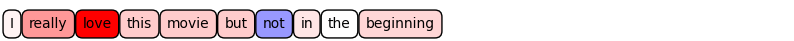

In [ ]:
plot_text_heatmap(
    "I really love this movie but not in the beginning".split(" "),
    np.array([0.02, 0.2, 0.5, 0.1, 0.1, 0.1, -0.2, 0.05, 0.00, 0.08]),
)

# "love" is shaded with strong red because its relevance score is rather high
# "not" is highlighted in light blue because of its negative score.

Review(id=97): this may not have the dramatic gut-wrenching impact of other holocaust films , but it 's a compelling story , mainly because of the way it 's told by the people who were there .
Pred class : positive ✓


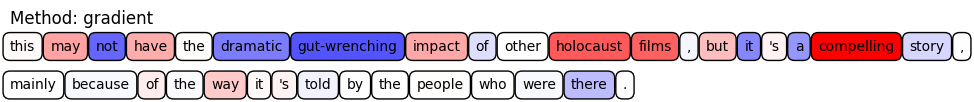

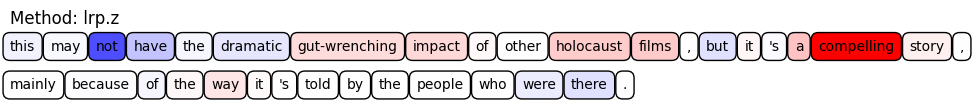

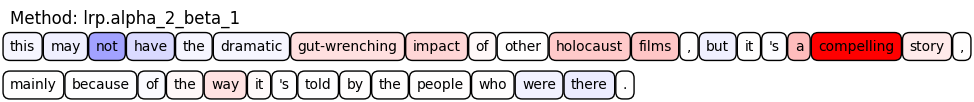

Review(id=175): without heavy-handedness , dong provides perspective with his intelligent grasp of human foibles and contradictions .
Pred class : positive ✓


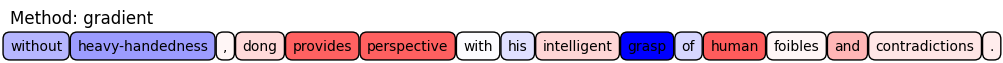

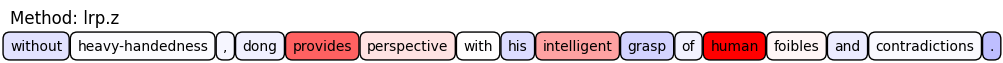

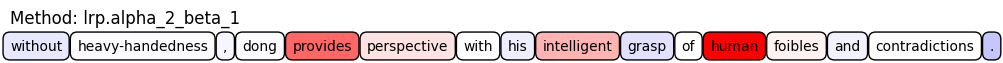

Review(id=1793): a frantic search for laughs , with a hit-to-miss ratio that does n't exactly favour the audience .
Pred class : negative ✓


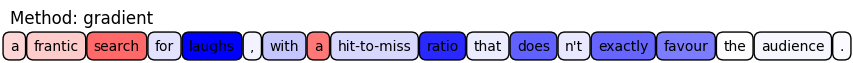

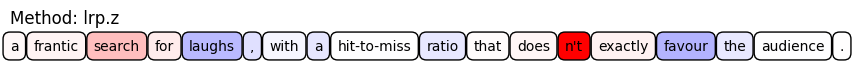

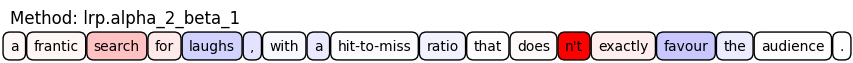

Review(id=1186): what you would end up with if you took orwell , bradbury , kafka , george lucas and the wachowski brothers and threw them into a blender .
Pred class : negative ✗ (positive)


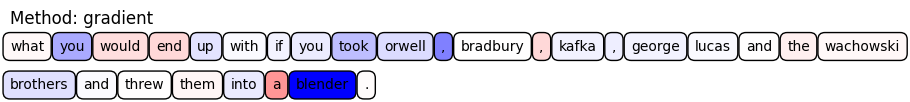

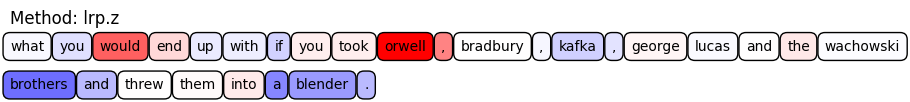

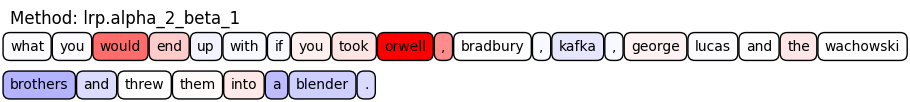

Review(id=354): a charming yet poignant tale of the irrevocable ties that bind .
Pred class : positive ✓


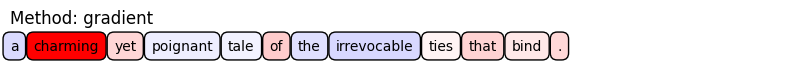

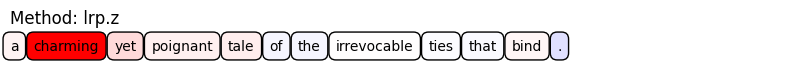

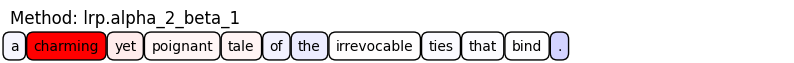

Review(id=1043): but he loses his focus when he concentrates on any single person .
Pred class : negative ✓


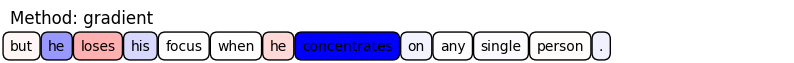

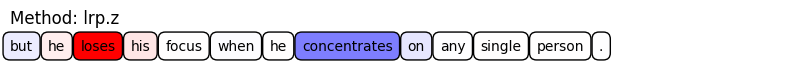

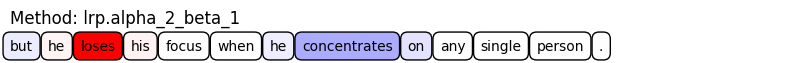

In [ ]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):
    words = [decoder[t] for t in list(DATASETS["testing"]["encoded_reviews"][idx])]

    print("Review(id=%d): %s" % (idx, " ".join(words)))
    y_true = DATASETS["testing"]["y"][idx]
    y_pred = test_sample_preds[i]

    print(
        "Pred class : %s %s"
        % (
            LABEL_IDX_TO_NAME[y_pred],
            "✓" if y_pred == y_true else "✗ (%s)" % LABEL_IDX_TO_NAME[y_true],
        )
    )

    for j, method in enumerate(methods):
        plot_text_heatmap(
            words, analysis[i, j].reshape(-1), title="Method: %s" % method, verbose=0
        )
        plt.show()

# Summary

The project involved data preprocessing, model building, training, explainability analysis using Innvestigate, and visualization of model interpretations to gain insights into sentiment analysis tasks.

1. Data Preparation:
   - Downloaded and processed sentiment analysis data from the Stanford Sentiment Treebank.
   - Cleaned and preprocessed text data, including handling Unicode encoding issues using the `ftfy` library.
   - Created mappings for sentiment labels and split labels, converted multi-class sentiment labels to binary classes, and prepared datasets for training, testing, and validation.

2. Model Building and Training:
   - Built a convolutional neural network (CNN) model for sentiment analysis using TensorFlow/Keras.
   - Trained the model on the prepared datasets with specified batch size and epochs, optimizing for categorical cross-entropy loss.

3. Explainability Analysis:
   - Used Innvestigate to perform explainability analysis on the trained model's predictions.
   - Employed different analysis methods such as "gradient," "lrp.z," and "lrp.alpha_2_beta_1" to understand which words in the reviews contributed most to the model's predictions.
   - Visualized the relevance scores of each word using heatmaps to provide insights into the model's decision-making process.

4. Evaluation and Visualization:
   - Evaluated the model's performance on the testing set, calculating test loss and accuracy.
   - Visualized the relevance scores of words in selected reviews to understand how the model interprets and analyzes text data.
